#  <center> Problem Set 4 <center>
<center> Spring 2021 <center>
<center> 3.100/3.322, 10.402/10.602, 20.301/20.401 <center>
<center> Due:10 pm ET on Thursday, Apr 22, 2021 <center>

## Part 2. SMILES-VAE

First, request a GPU by going to Edit/Notebook Settings/Hardware Accelerator.

In [1]:
# install RDKIT 

# This is a hack to install rdkit without needing to install anaconda which might take minutes 
# if you have anaconda installed, you can directly install rdkit from anaconda 
# url = 'https://anaconda.org/rdkit/rdkit/2018.09.1.0/download/linux-64/rdkit-2018.09.1.0-py36h71b666b_1.tar.bz2'
# !curl -L $url | tar xj lib
# !mv lib/python3.6/site-packages/rdkit /usr/local/lib/python3.7/dist-packages/

# x86 = '/usr/lib/x86_64-linux-gnu'
# !mv lib/*.so.* $x86/
# !ln -s $x86/libboost_python3-py36.so.1.65.1 $x86/libboost_python3.so.1.65.1

# Install tqdm progress bar 
# !pip install tqdm 

In [2]:
# Optional: mount your google drive to save model and files 

# from google.colab import drive
# drive.mount('/content/drive')
# mydrive = '/content/drive/MyDrive'

In [92]:
import numpy as np

import torch
import torch.utils.data
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import random

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger   
RDLogger.DisableLog('rdApp.*')

### Get data

In [4]:
# Get data 
# ! wget https://raw.githubusercontent.com/wwang2/ML4MolEng/master/psets/ps4/data/zinc_50k.csv
    
# Get pretrained VAE model 
# ! wget -O vae_checkpoint.pth https://github.com/wwang2/ML4MolEng/blob/master/psets/ps4/pretrained_checkpoints/vae-050-0.06.pth?raw=true

In [5]:
params = {
    "batch_size": 512
}

### 1.1 One-hot encode SMILES strings into padded numerical vectors

In [6]:
from sklearn import preprocessing

# Character list for SMILES string
moses_charset = ["2", "o", "C", "I", "O", "H", "n", "N", "=", "+", "#", "-", "c",
                 "B", "l", "7", "r", "S", "s", "4", "6", "[", "5", "]", "F", "3", 
                 "P", "(", ")", "1", " "]

# Define encoder 
enc = preprocessing.LabelEncoder().fit(moses_charset)

# Read data 
df = pd.read_csv("./data/zinc_50k.csv")

Encode SMILES string into padded categorial vectors.

In [7]:
################ Code #################

smiles_strings = list(df["SMILES"])
max_len = max(map(lambda x: len(x), smiles_strings))

smiles_encoded = []
for smiles in smiles_strings:
    padded = list(smiles + " " * (max_len - len(smiles)))
    encoded = enc.transform(padded)
    smiles_encoded.append(encoded)

################ Code #################

Make train/validation/test datasets.

In [8]:
################ Code #################

smiles_enc_train, smiles_enc_valtest = train_test_split(smiles_encoded, train_size=7/10)
smiles_enc_val, smiles_enc_test = train_test_split(smiles_enc_valtest, test_size=2/3)

X_train = TensorDataset(
        torch.LongTensor(np.array(smiles_enc_train))
    )
X_val = TensorDataset(
        torch.LongTensor(np.array(smiles_enc_val))
    )
X_test = TensorDataset(
        torch.LongTensor(np.array(smiles_enc_test))
    )

train_loader = DataLoader(X_train, batch_size=params["batch_size"], shuffle=False)
val_loader = DataLoader(X_val, batch_size=params["batch_size"], shuffle=False)
test_loader = DataLoader(X_test, batch_size=params["batch_size"], shuffle=False)

################ Code #################

### 1.2 Implement the reparametrization trick for VAE

In [9]:
# Molecular VAE model 

class MolVAE(nn.Module):
    def __init__(self, rnn_enc_hid_dim, enc_nconv,
               encoder_hid, z_dim, 
               rnn_dec_hid_dim, dec_nconv, smiles_len, nchar
           ):
        """
        SMILES VAE model 

            rnn_enc_hid_dim: hidden dimension for the GRU encoder 
            enc_nconv: number of recurrent layers for the GRU decoder
            encoder_hid: dimension of GUR encoder readout
            z_dim: number of latent variable 
            rnn_dec_hid_dim: hidden dimension for the GRU decoder 
            dec_nconv: number of recurrent layers for the GRU decoder
            smiles_len: total length of padded SMILES string 
            nchar: number of possible characters 
        """
        super(MolVAE, self).__init__()
        
        self.smiles_len = smiles_len
        self.nchar = nchar
        # Embedding layer
        self.embed = nn.Embedding(self.nchar, rnn_enc_hid_dim)
        # Encoding GRU
        self.rnn_enc = nn.GRU(rnn_enc_hid_dim, rnn_enc_hid_dim, enc_nconv, batch_first=True)
        # MLP to transfrom hidden output from Encoding GRU
        self.mlp0 = nn.Linear(rnn_enc_hid_dim, encoder_hid)
        # Network to parametrize mu
        self.mu_network = nn.Linear(encoder_hid, z_dim)
        # Network to parametrize log variance
        self.logvar_network = nn.Linear(encoder_hid, z_dim)
        # Decoding GRU
        self.rnn_dec = nn.GRU(z_dim, rnn_dec_hid_dim, dec_nconv, batch_first=True)
        # Output SMILES characters
        self.readout = nn.Linear(rnn_dec_hid_dim, self.nchar)

    def encode(self, x):
        """output mean and logVariance of the encoded SMILES"""
        output, hn = self.rnn_enc(x)
        h = F.relu(self.mlp0(hn[-1]))
        return self.mu_network(h), self.logvar_network(h)
    
    def get_std(self, logvar):
        """transform log variance to standard deviation"""
        ################ Code #################
        logvar = torch.exp(0.5 * logvar)
        return logvar
        ################ Code #################

    def reparameterize(self, mu, std):
        """the reparametrization trick"""
        if self.training:
            ################ Code #################
            r = torch.randn_like(mu)
            z = mu + std * r
            return z
           ################ Code ################# 
        else:
            return mu

    def decode(self, z):
        """decoder to reconstruct latent variable back to SMILES"""
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, self.smiles_len, 1)
        out, h = self.rnn_dec(z)
        out_reshape = out.contiguous().view(-1, out.size(-1))
        
        y0 = self.readout(out_reshape)
        y = y0.contiguous().view(out.size(0), -1, y0.size(-1))
        return y

    def forward(self, x):
        x_embed = self.embed(x) # Get SMILES embedding 
        mu, logvar = self.encode(x_embed) # Encoding SMILES to latent representations 
        std = self.get_std(logvar) # transform log variance to std.
        z = self.reparameterize(mu, std) # reparametrization trick 
        smiles_recon = self.decode(z)  # reconstruct SMILES string 
        return smiles_recon, mu, std

In [10]:
################ Code #################

model = MolVAE(rnn_enc_hid_dim=367, enc_nconv=2, 
    encoder_hid=512, z_dim=171, rnn_dec_hid_dim=512,
    dec_nconv=1, nchar=31, smiles_len=max_len
    )

for i in train_loader:
    i = i[0]
    out, mu, std = model.forward(i)
    break

################ Code #################

Sample a 1D Gaussian distribution with mean = 0, std = 1.

In [11]:
model = MolVAE(rnn_enc_hid_dim=367, enc_nconv=2, 
    encoder_hid=512, z_dim=171, rnn_dec_hid_dim=512,
    dec_nconv=1, nchar=31, smiles_len=max_len
    )

mu = np.zeros(1000)
std = np.ones(1000)
sample = model.reparameterize(torch.Tensor(mu), torch.Tensor(std))

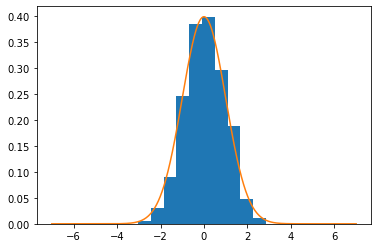

In [12]:
# Compare your sampling with N(0, 1)

import matplotlib.pyplot as plt
from scipy.stats import norm

plt.hist(sample.detach().cpu().numpy(), density=True)

# Plot a 1d unit Gaussian 
x_axis = np.arange(-7, 7, 0.001)
plt.plot(x_axis, norm.pdf(x_axis,0,1)) # Mean = 0, SD = 1.
plt.show()


### 1.3 Implement the SMILES VAE loss function

In [42]:
def loss_function(recon_x, x, mu, var):
    ################ Code #################
    
    # reconstruction loss 
    L_recon = F.cross_entropy(recon_x.swapaxes(1, 2), x)
    # KL loss
    L_kl = torch.mean(
        0.5 * torch.sum(torch.square(mu) + var - torch.log(var) - 1, dim=1),
        dim=0)
    
    ################ Code #################
    return L_recon, L_kl

In [43]:
# Helper functions 
def index2smiles(mol_index, enc):
    '''Transform Your An array of character index back to SMILES'''
    smiles_charlist = enc.inverse_transform(mol_index)
    smiles = ''.join(smiles_charlist).strip(" ")
    
    return smiles

def check_smiles_valid(smiles):
    '''Check if SMILES string is valid'''
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        valid = True 
    else:
        valid = False 
    return valid

def sample_recon(model, epoch, dataloader, enc, n_sample=500):
    '''Randomly sample from data loader to get reconstructed SMILES and test if it is valid'''
    # evaluation mode 
    model.eval()
    
    # Randomly select samples 
    random_mol = random.choices( range( len(dataloader.dataset) ), k=n_sample)
    x_mol = train_loader.dataset.__getitem__(random_mol)[0]
    x_mol = x_mol.to(device)
    
    # Get reconstructed Molecule 
    mol_recon, mu, logvar = model(x_mol)
    mol_index = mol_recon.detach().cpu().numpy().argmax(-1).squeeze()
    mol_orig = x_mol.detach().cpu().numpy()
    
    # Show the first reconstructed SMILES
    print("epoch {} sample orig SMILES: {}".format(epoch,  index2smiles(mol_orig[0], enc)))
    print("epoch {} sample recon SMILES: {}".format(epoch,  index2smiles(mol_index[0], enc)))
    
    valid_count = 0 
    for indexed_smiles in mol_index:
        smiles = index2smiles(indexed_smiles, enc)
        valid = check_smiles_valid(smiles)
        
        if valid: 
            valid_count += 1
    
    print("{}/{} SMILES are valid".format(valid_count, n_sample))

def loop(model, loader, epoch, beta=0.05, evaluation=False):
    """
    Train/test your VAE model
    """
    
    if evaluation:
        model.eval()
        mode = "eval"
    else:
        model.train()
        mode = 'train'
    batch_losses = []
        
    tqdm_data = tqdm(loader, position=0, leave=True, desc='{} (epoch #{})'.format(mode, epoch))
    for data in tqdm_data:
        
        x = data[0].to(device)
        recon_batch, mu, std = model(x)
        loss_recon, loss_kl = loss_function(recon_batch, x, mu, std)
        loss = loss_recon + beta * loss_kl     
        
        if not evaluation:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        batch_losses.append(loss.item())

        postfix = ['recon loss={:.3f}'.format(loss_recon.item()) ,
                   'KL loss={:.3f}'.format(loss_kl.item()) ,
                   'total loss={:.3f}'.format(loss.item()) , 
                   'avg. loss={:.3f}'.format(np.array(batch_losses).mean())]
        
        tqdm_data.set_postfix_str(' '.join(postfix))
    
    return np.array(batch_losses).mean()

### 1.4  Train your model

In [50]:
device = 0

model = MolVAE(rnn_enc_hid_dim=367, enc_nconv=2, 
    encoder_hid=512, z_dim=171, rnn_dec_hid_dim=512,
    dec_nconv=1, nchar=31, smiles_len=max_len
    )
                      
model = model.to(device)

# load pretrained model 
model.load_state_dict(torch.load("./pretrained_checkpoints/vae-050-0.06.pth"))

<All keys matched successfully>

In [51]:
# optimizer = optim.Adam(model.parameters(), lr=5e-5)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

In [53]:
# epochs = 50
# beta = 0.001

# for epoch in range(0, epochs):
#     sample_recon(model, epoch, val_loader, enc)
#     train_loss = loop(model, train_loader, epoch, beta=beta)
#     val_loss = loop(model, val_loader, epoch, beta=beta, evaluation=True)
#     scheduler.step(val_loss)
    
#     # optional: save model 
# #     if epoch % 15 == 0:
# #         torch.save(model.state_dict(),
# #                 './{}/vae-{:03d}-{:.2f}.pth'.format(mydrive, epoch, train_loss))
        
# #         torch.save(optimizer.state_dict(),
# #             './{}/optim-{:03d}-{:.2f}.pth'.format(mydrive, epoch, train_loss))

#     if epoch == 0:
#         best_loss = train_loss.item()
#     else:
#         if train_loss.item() < best_loss:
#             best_loss = train_loss.item()

epoch 0 sample orig SMILES: O=C(Nc1ccc2cn[nH]c2c1)c1csc(Nc2ncccn2)n1
epoch 0 sample recon SMILES: O=C(Nc1ccc2cn[nH]c2c1)c1ccc(NCc2ccccc2)n1
123/500 SMILES are valid


eval (epoch #0): 100%|███████████████████| 10/10 [00:00<00:00, 32.74it/s, recon loss=0.026 KL loss=69.277 total loss=0.095 avg. loss=0.095]


epoch 1 sample orig SMILES: CN(C)S(=O)(=O)c1cc(NC(=O)c2ccccn2)ccc1Cl
epoch 1 sample recon SMILES: CN(C)S(=O)(=O)c1cc(NC(=O)c2ccccn2)ccc1Cl
430/500 SMILES are valid


eval (epoch #1): 100%|███████████████████| 10/10 [00:00<00:00, 33.00it/s, recon loss=0.025 KL loss=65.285 total loss=0.090 avg. loss=0.090]


epoch 2 sample orig SMILES: O=S(=O)(c1ccc(-c2ccccn2)s1)N1CCCCC1
epoch 2 sample recon SMILES: O=S(=O)(c1ccc(-c2ccccn2)s1)N1CCCCC1
446/500 SMILES are valid


eval (epoch #2): 100%|███████████████████| 10/10 [00:00<00:00, 32.83it/s, recon loss=0.025 KL loss=65.138 total loss=0.090 avg. loss=0.090]


epoch 3 sample orig SMILES: Cc1nc(Nc2ncnc(-n3cnc4ccccc43)c2N)sc1C
epoch 3 sample recon SMILES: Cc1nc(Nc2ccnc(Nn3nnc4ccccc33)c2N)s1CC
444/500 SMILES are valid


eval (epoch #3): 100%|███████████████████| 10/10 [00:00<00:00, 32.84it/s, recon loss=0.025 KL loss=65.369 total loss=0.091 avg. loss=0.090]


epoch 4 sample orig SMILES: CCc1ccc(S(=O)(=O)Nc2ccc(N)c(F)c2)cc1
epoch 4 sample recon SMILES: CCc1ccc(S(=O)(=O)Nc2ccc(N)c(F)c2)cc1
443/500 SMILES are valid


eval (epoch #4): 100%|███████████████████| 10/10 [00:00<00:00, 32.49it/s, recon loss=0.026 KL loss=64.203 total loss=0.090 avg. loss=0.089]


epoch 5 sample orig SMILES: Cc1ccccc1OCC(=O)NCCc1nnc(-c2ccccc2)o1
epoch 5 sample recon SMILES: Cc1ccccc1OCC(=O)NCCc1nnc(-c2ccccc2)o1
443/500 SMILES are valid


eval (epoch #5): 100%|███████████████████| 10/10 [00:00<00:00, 32.90it/s, recon loss=0.026 KL loss=64.201 total loss=0.090 avg. loss=0.089]


epoch 6 sample orig SMILES: O=C(NCCCNC(=O)c1scnc1C1CC1)c1ccc(O)cc1
epoch 6 sample recon SMILES: O=C(NCCCNC(=O)c1scnc1C1CC1)c1ccc(O)cc1
457/500 SMILES are valid


eval (epoch #6): 100%|███████████████████| 10/10 [00:00<00:00, 32.97it/s, recon loss=0.026 KL loss=63.632 total loss=0.089 avg. loss=0.088]


epoch 7 sample orig SMILES: CSc1ccccc1NC(=O)c1c[nH]c2ccccc12
epoch 7 sample recon SMILES: CSc1ccccc1NC(=O)c1c[nH]c2ccccc12
444/500 SMILES are valid


eval (epoch #7): 100%|███████████████████| 10/10 [00:00<00:00, 32.73it/s, recon loss=0.025 KL loss=63.564 total loss=0.089 avg. loss=0.088]


epoch 8 sample orig SMILES: N#Cc1ccc(OCCOC(=O)c2ccco2)cc1
epoch 8 sample recon SMILES: N#Cc1ccc(OCCOC(=O)c2ccco2)cc1
448/500 SMILES are valid


eval (epoch #8): 100%|███████████████████| 10/10 [00:00<00:00, 32.21it/s, recon loss=0.025 KL loss=62.209 total loss=0.087 avg. loss=0.087]


epoch 9 sample orig SMILES: NC(=O)NCc1ccc(C(=O)OCC2CC2(Cl)Cl)cc1
epoch 9 sample recon SMILES: NC(=O)NCc1ccc(C(=O)OCC2CC2(Cl)Cl)cc1
450/500 SMILES are valid


eval (epoch #9): 100%|███████████████████| 10/10 [00:00<00:00, 32.82it/s, recon loss=0.024 KL loss=62.741 total loss=0.087 avg. loss=0.087]


epoch 10 sample orig SMILES: COCCN1CCN(C(=O)c2ccnc(-n3ccnc3)c2)CC1=O
epoch 10 sample recon SMILES: COCCN1CCN(C(=O)c2ccnc(-n3ccnc3)c2)CC1=O
451/500 SMILES are valid


eval (epoch #10): 100%|██████████████████| 10/10 [00:00<00:00, 32.80it/s, recon loss=0.025 KL loss=62.012 total loss=0.087 avg. loss=0.086]


epoch 11 sample orig SMILES: Cc1csc(=O)n1CCC(=O)Oc1ccc(C#N)cc1
epoch 11 sample recon SMILES: Cc1csc(=O)n1CCC(=O)Oc1ccc(C#N)cc1
436/500 SMILES are valid


eval (epoch #11): 100%|██████████████████| 10/10 [00:00<00:00, 32.81it/s, recon loss=0.026 KL loss=65.180 total loss=0.091 avg. loss=0.090]


epoch 12 sample orig SMILES: Cc1cnn(CCC(=O)N2CC(C)CN(C)c3ccccc32)c1
epoch 12 sample recon SMILES: Cc1cnn(CCC(=O)N2CC(C)NN(C)c3ccccc32)c1
438/500 SMILES are valid


eval (epoch #12): 100%|██████████████████| 10/10 [00:00<00:00, 32.79it/s, recon loss=0.025 KL loss=62.282 total loss=0.087 avg. loss=0.087]


epoch 13 sample orig SMILES: CC(Cc1ccccc1F)NC(=O)c1scnc1C1CC1
epoch 13 sample recon SMILES: CC(Cc1ccccc1F)NC(=O)c1scnc1C1CC1
452/500 SMILES are valid


eval (epoch #13): 100%|██████████████████| 10/10 [00:00<00:00, 32.49it/s, recon loss=0.025 KL loss=62.400 total loss=0.087 avg. loss=0.087]


epoch 14 sample orig SMILES: O=C(Nc1ccc(Br)cc1)c1cccc(O)c1
epoch 14 sample recon SMILES: O=C(Nc1ccc(Br)cc1)c1cccc(O)c1
446/500 SMILES are valid


eval (epoch #14): 100%|██████████████████| 10/10 [00:00<00:00, 32.61it/s, recon loss=0.025 KL loss=61.815 total loss=0.086 avg. loss=0.086]


epoch 15 sample orig SMILES: Cc1c(C(=O)Nc2nc3ccccc3s2)nnn1Cc1ccccc1
epoch 15 sample recon SMILES: Cc1c(C(=O)Nc2nc3ccccc3s2)nnn1Cc1ccccc1
444/500 SMILES are valid


eval (epoch #15): 100%|██████████████████| 10/10 [00:00<00:00, 32.68it/s, recon loss=0.043 KL loss=68.261 total loss=0.111 avg. loss=0.106]


epoch 16 sample orig SMILES: Cc1nn(C)c(C)c1CN(C(=O)C1COc2ccccc2C1)C(C)C
epoch 16 sample recon SMILES: Cc1nn(C)c(C)c1CN(C(=O)C1COc2ccccc2C1)C(C)C
427/500 SMILES are valid


eval (epoch #16): 100%|██████████████████| 10/10 [00:00<00:00, 32.53it/s, recon loss=0.027 KL loss=64.579 total loss=0.092 avg. loss=0.090]


epoch 17 sample orig SMILES: Cc1ccc(NC(=O)c2nc(-c3cccs3)oc2C)nc1
epoch 17 sample recon SMILES: Cc1ccc(NC(=O)c2nc(-c3ccco3)oc2C)nc1
449/500 SMILES are valid


eval (epoch #17): 100%|██████████████████| 10/10 [00:00<00:00, 33.23it/s, recon loss=0.027 KL loss=62.439 total loss=0.090 avg. loss=0.087]


epoch 18 sample orig SMILES: Cc1cccc(NC(=O)NCCNc2ccc(-n3cccn3)nn2)c1
epoch 18 sample recon SMILES: Cc1cccc(NC(=O)NCCNc2ccc(-n3cccn3)nn2)c1
449/500 SMILES are valid


eval (epoch #18): 100%|██████████████████| 10/10 [00:00<00:00, 32.99it/s, recon loss=0.026 KL loss=62.198 total loss=0.088 avg. loss=0.087]


epoch 19 sample orig SMILES: O=C(NCc1ccc(-n2ccnc2)nc1)NCC1(c2ccccc2)CC1
epoch 19 sample recon SMILES: O=C(NCc1ccc(-n2ccnc2)nc1)NC1C(c2ccccc2)CC1
451/500 SMILES are valid


eval (epoch #19): 100%|██████████████████| 10/10 [00:00<00:00, 32.83it/s, recon loss=0.026 KL loss=61.992 total loss=0.088 avg. loss=0.086]


epoch 20 sample orig SMILES: Cn1c(CNc2ccc(-n3ccnc3)cc2)nc2ccccc21
epoch 20 sample recon SMILES: Cn1c(CNc2ccc(-n3ccnc3)cc2)nc2ccccc21
451/500 SMILES are valid


eval (epoch #20): 100%|██████████████████| 10/10 [00:00<00:00, 33.04it/s, recon loss=0.026 KL loss=61.523 total loss=0.088 avg. loss=0.086]


epoch 21 sample orig SMILES: O=C1NC(CCC(=O)N2CCCC2)C(O)=Nc2ccccc21
epoch 21 sample recon SMILES: O=C1NC(CCC(=O)N2CCCC2)C(C)=Nc2ccccc21
457/500 SMILES are valid


eval (epoch #21): 100%|██████████████████| 10/10 [00:00<00:00, 32.92it/s, recon loss=0.025 KL loss=61.730 total loss=0.087 avg. loss=0.086]


epoch 22 sample orig SMILES: CCOc1ccccc1-c1cc2ncc(N)cn2n1
epoch 22 sample recon SMILES: CCOc1ccccc1-c1nc2ncc(N)cn2n1
447/500 SMILES are valid


eval (epoch #22): 100%|██████████████████| 10/10 [00:00<00:00, 32.77it/s, recon loss=0.025 KL loss=61.709 total loss=0.086 avg. loss=0.086]


epoch 23 sample orig SMILES: COC(=O)c1sccc1NC(=O)n1ncc2cc(Cl)ccc21
epoch 23 sample recon SMILES: COC(=O)c1sccc1NC(=O)c1ncc2cc(Cl)ccc21
449/500 SMILES are valid


eval (epoch #23): 100%|██████████████████| 10/10 [00:00<00:00, 32.91it/s, recon loss=0.025 KL loss=61.531 total loss=0.086 avg. loss=0.085]


epoch 24 sample orig SMILES: O=C1CC(c2ccccc2)c2cnn(C3CCCC3)c2N1
epoch 24 sample recon SMILES: O=C1CC(c2ccccc2)c2cnn(C3CCCC3)c2N1
458/500 SMILES are valid


eval (epoch #24): 100%|██████████████████| 10/10 [00:00<00:00, 32.80it/s, recon loss=0.025 KL loss=61.307 total loss=0.087 avg. loss=0.085]


epoch 25 sample orig SMILES: Cc1ccc(C(=O)Nc2cc(N3CCCCC3)ncn2)c(C)c1
epoch 25 sample recon SMILES: Cc1ccc(C(=O)Nc2cc(N3CCCCC3)ncn2)c(C)c1
441/500 SMILES are valid


eval (epoch #25): 100%|██████████████████| 10/10 [00:00<00:00, 32.80it/s, recon loss=0.026 KL loss=61.332 total loss=0.087 avg. loss=0.085]


epoch 26 sample orig SMILES: CCCn1c(=O)n(Cc2cccc(C(N)=O)c2)c2ccccc21
epoch 26 sample recon SMILES: CCCn1c(=O)n(Cc2cccc(C(N)=O)c2)c2ccccc21
454/500 SMILES are valid


eval (epoch #26): 100%|██████████████████| 10/10 [00:00<00:00, 32.82it/s, recon loss=0.026 KL loss=64.708 total loss=0.091 avg. loss=0.090]


epoch 27 sample orig SMILES: O=C(Cn1cnnn1)Nc1ccc(F)c(F)c1F
epoch 27 sample recon SMILES: O=C(Cn1cnnn1)Nc1ccc(F)c(F)c1F
453/500 SMILES are valid


eval (epoch #27): 100%|██████████████████| 10/10 [00:00<00:00, 32.96it/s, recon loss=0.031 KL loss=72.858 total loss=0.104 avg. loss=0.103]


epoch 28 sample orig SMILES: Nc1ccc(-c2nc3cc(C(F)(F)F)ccc3[nH]2)cc1
epoch 28 sample recon SMILES: Nc1ccc(-c2nc3cc(C(F)(F)F)ccc3[nH]2)cc1
444/500 SMILES are valid


eval (epoch #28): 100%|██████████████████| 10/10 [00:00<00:00, 32.77it/s, recon loss=0.028 KL loss=65.772 total loss=0.094 avg. loss=0.091]


epoch 29 sample orig SMILES: O=c1oc2ccc(Cl)cc2c(=O)n1-c1ccc(F)cc1
epoch 29 sample recon SMILES: O=c1oc2ccc(Cl)cc2c(=O)n1-c1ccc(F)cc1
448/500 SMILES are valid


eval (epoch #29): 100%|██████████████████| 10/10 [00:00<00:00, 32.68it/s, recon loss=0.027 KL loss=63.285 total loss=0.091 avg. loss=0.088]


epoch 30 sample orig SMILES: Nc1nc(CSc2nnnn2C2CCCCC2)nc2ccccc12
epoch 30 sample recon SMILES: Nc1nc(CSc2nnnn2C2CCCCC2)nc2ccccc12
451/500 SMILES are valid


eval (epoch #30): 100%|██████████████████| 10/10 [00:00<00:00, 32.64it/s, recon loss=0.027 KL loss=62.053 total loss=0.089 avg. loss=0.087]


epoch 31 sample orig SMILES: COc1ccc(S(N)(=O)=O)cc1C(=O)NCC1CC1C
epoch 31 sample recon SMILES: COc1ccc(S(N)(=O)=O)cc1C(=O)NCC1CC1C
456/500 SMILES are valid


eval (epoch #31): 100%|██████████████████| 10/10 [00:00<00:00, 32.70it/s, recon loss=0.027 KL loss=61.851 total loss=0.089 avg. loss=0.086]


Epoch    32: reducing learning rate of group 0 to 2.5000e-05.
epoch 32 sample orig SMILES: O=C(NCc1nc2ccccc2s1)NC1CCC(O)CC1
epoch 32 sample recon SMILES: O=C(NCc1nc2ccccc2s1)NC1CCC(O)CC1
457/500 SMILES are valid


eval (epoch #32): 100%|██████████████████| 10/10 [00:00<00:00, 32.77it/s, recon loss=0.027 KL loss=61.828 total loss=0.089 avg. loss=0.086]


epoch 33 sample orig SMILES: CCCC(=O)Nc1ccc(NCC(=O)NC(C)C)cc1
epoch 33 sample recon SMILES: CCCC(=O)Nc1ccc(NCC(=O)NC(C)C)cc1
458/500 SMILES are valid


eval (epoch #33): 100%|██████████████████| 10/10 [00:00<00:00, 32.79it/s, recon loss=0.027 KL loss=61.350 total loss=0.089 avg. loss=0.085]


epoch 34 sample orig SMILES: N#CCCN1CCN(C(=O)Cc2c[nH]c3ccccc23)CC1
epoch 34 sample recon SMILES: N#CCCN1CCN(C(=O)Cc2c[nH]c3ccccc23)CC1
466/500 SMILES are valid


eval (epoch #34): 100%|██████████████████| 10/10 [00:00<00:00, 32.72it/s, recon loss=0.027 KL loss=61.412 total loss=0.088 avg. loss=0.086]


epoch 35 sample orig SMILES: CC(C)COc1ccc(CNS(=O)(=O)c2cccnc2)cc1
epoch 35 sample recon SMILES: CC(C)COc1ccc(CNS(=O)(=O)c2cccnc2)cc1
453/500 SMILES are valid


eval (epoch #35): 100%|██████████████████| 10/10 [00:00<00:00, 33.18it/s, recon loss=0.027 KL loss=61.327 total loss=0.088 avg. loss=0.086]


epoch 36 sample orig SMILES: O=C(Cn1nc(-c2ccccc2)c2ccccc21)NCc1cccnc1
epoch 36 sample recon SMILES: O=C(Cn1nc(-c2ccccc2)c2ccccc21)NCc1cccnc1
452/500 SMILES are valid


eval (epoch #36): 100%|██████████████████| 10/10 [00:00<00:00, 32.93it/s, recon loss=0.027 KL loss=61.159 total loss=0.088 avg. loss=0.085]


epoch 37 sample orig SMILES: N#Cc1ccccc1OCC(=O)Nc1sccc1C(=O)NC1CC1
epoch 37 sample recon SMILES: N#Cc1ccccc1OCC(=O)Nc1sccc1C(=O)NC1CC1
455/500 SMILES are valid


eval (epoch #37): 100%|██████████████████| 10/10 [00:00<00:00, 32.80it/s, recon loss=0.027 KL loss=61.001 total loss=0.088 avg. loss=0.085]


epoch 38 sample orig SMILES: CC(=O)c1cc(C(=O)NCc2ccc(F)cc2)n(C)c1
epoch 38 sample recon SMILES: CC(=O)c1cc(C(=O)NCc2ccc(F)cc2)n(C)c1
442/500 SMILES are valid


eval (epoch #38): 100%|██████████████████| 10/10 [00:00<00:00, 32.78it/s, recon loss=0.027 KL loss=60.855 total loss=0.088 avg. loss=0.085]


epoch 39 sample orig SMILES: CC(Sc1n[nH]c(N)n1)C(=O)N1CCc2ccccc21
epoch 39 sample recon SMILES: CC(Sc1n[nH]c(N)n1)C(=O)N1CCc2ccccc21
455/500 SMILES are valid


eval (epoch #39): 100%|██████████████████| 10/10 [00:00<00:00, 32.51it/s, recon loss=0.026 KL loss=60.871 total loss=0.087 avg. loss=0.085]


epoch 40 sample orig SMILES: NC(=O)c1ccc(CN(C2CC2)S(=O)(=O)c2cccnc2)cc1
epoch 40 sample recon SMILES: NC(=O)c1ccc(CN(C2CC2)S(=O)(=O)c2cccnc2)cc1
445/500 SMILES are valid


eval (epoch #40): 100%|██████████████████| 10/10 [00:00<00:00, 32.60it/s, recon loss=0.027 KL loss=60.908 total loss=0.088 avg. loss=0.085]


epoch 41 sample orig SMILES: CCOC(=O)CN(C)S(=O)(=O)c1ccn(C)c1
epoch 41 sample recon SMILES: CCOC(=O)CN(C)S(=O)(=O)c1ccn(C)c1
459/500 SMILES are valid


eval (epoch #41): 100%|██████████████████| 10/10 [00:00<00:00, 32.78it/s, recon loss=0.027 KL loss=61.117 total loss=0.088 avg. loss=0.085]


epoch 42 sample orig SMILES: CCc1ccccc1OCC(=O)N1CCC(CC(N)=O)CC1
epoch 42 sample recon SMILES: CCc1ccccc1OCC(=O)N1CCC(CC(N)=O)CC1
453/500 SMILES are valid


eval (epoch #42): 100%|██████████████████| 10/10 [00:00<00:00, 32.54it/s, recon loss=0.026 KL loss=60.809 total loss=0.087 avg. loss=0.085]


epoch 43 sample orig SMILES: O=C(CCC1CCCC1)N1CCN(CC(O)c2ccco2)CC1
epoch 43 sample recon SMILES: O=C(CCC1CCCC1)N1CCN(CC(O)c2ccco2)CC1
451/500 SMILES are valid


eval (epoch #43): 100%|██████████████████| 10/10 [00:00<00:00, 32.90it/s, recon loss=0.027 KL loss=60.842 total loss=0.088 avg. loss=0.085]


epoch 44 sample orig SMILES: COc1cccc(C(=O)OCc2scnc2C)c1
epoch 44 sample recon SMILES: COc1cccc(C(=O)OCc2scnc2C)c1
453/500 SMILES are valid


eval (epoch #44): 100%|██████████████████| 10/10 [00:00<00:00, 32.91it/s, recon loss=0.026 KL loss=60.802 total loss=0.087 avg. loss=0.085]


epoch 45 sample orig SMILES: Nc1c(C(=O)c2c[nH]c3ccccc23)nnn1-c1ccccc1
epoch 45 sample recon SMILES: Nc1c(C(=O)c2c[nH]c3ccccc23)nnn1-c1ccccc1
462/500 SMILES are valid


eval (epoch #45): 100%|██████████████████| 10/10 [00:00<00:00, 32.62it/s, recon loss=0.026 KL loss=60.652 total loss=0.087 avg. loss=0.084]


epoch 46 sample orig SMILES: Fc1ccc(C2NCCc3c2cc(F)c(Cl)c3F)nc1
epoch 46 sample recon SMILES: Fc1ccc(C2NCCc3c2cc(F)c(Cl)c3F)nc1
459/500 SMILES are valid


eval (epoch #46): 100%|██████████████████| 10/10 [00:00<00:00, 32.90it/s, recon loss=0.026 KL loss=60.473 total loss=0.087 avg. loss=0.084]


epoch 47 sample orig SMILES: CCOC(=O)C(C)NC(=O)c1csc2ccccc12
epoch 47 sample recon SMILES: CCOC(=O)C(C)NC(=O)c1csc2ccccc12
466/500 SMILES are valid


eval (epoch #47): 100%|██████████████████| 10/10 [00:00<00:00, 32.88it/s, recon loss=0.027 KL loss=60.476 total loss=0.087 avg. loss=0.084]


epoch 48 sample orig SMILES: CC1CC1C(=O)Nc1nc(-c2cccc(O)c2)cs1
epoch 48 sample recon SMILES: CC1CC1C(=O)Nc1nc(-c2cccc(O)c2)cs1
456/500 SMILES are valid


eval (epoch #48): 100%|██████████████████| 10/10 [00:00<00:00, 32.80it/s, recon loss=0.026 KL loss=60.573 total loss=0.087 avg. loss=0.084]


epoch 49 sample orig SMILES: Cc1cccc(C(=O)Nc2cccc(N3CCCCC3=O)c2)c1
epoch 49 sample recon SMILES: Cc1cccc(C(=O)Nc2cccc(N3CCCCC3=O)c2)c1
439/500 SMILES are valid


eval (epoch #49): 100%|██████████████████| 10/10 [00:00<00:00, 32.66it/s, recon loss=0.027 KL loss=61.144 total loss=0.088 avg. loss=0.085]


In [55]:
torch.save(model.state_dict(), f"./saved_models_part2/vae-{epoch:03d}-{train_loss:.2f}.pth")

### 1.5 Sample new molecules 

In [147]:
################ Code #################

# grab random molecules
id1, id2 = random.sample(range(len(X_test)), 2)
mol1, mol2 = X_test[id1][0], X_test[id2][0]

# get z
model = model.to("cpu")
_, mu, _ = model(torch.vstack([mol1, mol2]))

mu_interp = []
for weight in np.linspace(0.0, 1, 101):
    mu_interp.append(torch.lerp(mu[0], mu[1], weight))
mu_interp = torch.vstack(mu_interp)

vae_mols = model.decode(mu_interp).detach().cpu().numpy().argmax(-1).squeeze()

vae_smiles = [index2smiles(mol1, enc)]
for vae_mol in vae_mols:
    vae_smiles.append(index2smiles(vae_mol, enc))
vae_smiles.append(index2smiles(mol2, enc))

vae_smiles = [k for k, _ in groupby(vae_smiles)]

################ Code #################

Visualize molecular line drawings for the molecules you generated.

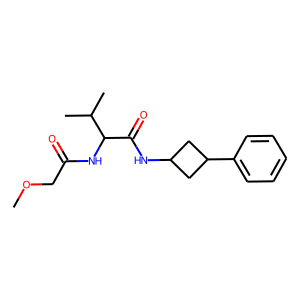

[1] invalid smiles: COCC(=O)NC(C(=O)NC1CC(22cccc22)C1)C(C)C
[2] invalid smiles: COCC(=O)NC(C(=O)NC1CCc2ccccc2)CC))(C)C
[3] invalid smiles: COCC(=O)NC(C(=O)NC1CCc2ccccc2)C1)C(C)C
[4] invalid smiles: COCC(=O)NC(C(=O)NC1Ccc2cccc22)C1)C(C)C
[5] invalid smiles: COCC(=O)NC(C(=O)NC1Ccc2cccc2))C1)C(C)C
[6] invalid smiles: COCC(=O)NC(C(=O)NC1Cc2ccccc2)CC))(C)C
[7] invalid smiles: COCC(=O)NC(C(=O)NC1Cc2ccccc2)C1))(C)C
[8] invalid smiles: COCC(=O)NC(C(=O)NC1Cc2ccccc2)C1)C(C)C
[9] invalid smiles: COCC(=O)NC(C(=O)N1CCc2ccccc2)C1)C(C)C
[10] invalid smiles: COCC(=O)NC(C(=O)C1C(c2cccc22)C1)C(C)C
[11] invalid smiles: COCC(=O)NC(C(=)NC1C(c2cccc22)C1)C(C)C
[12] invalid smiles: COCC(=O)NC(C(=)NC1Ccc2cccs2)CC1)C(CC
[13] invalid smiles: COCC(=O)NC(C=O)NC1(c2ccccc2)C1)C(C)C
[14] invalid smiles: COCC(=O)NC((=O)NC1(c2cccc22)C1)C(C)C
[15] invalid smiles: COC((=O)NCC(=O)NC1(c2cccc22)C1)C(C)C
[16] invalid smiles: COC((=O)NCC(=O)NC1(c2cccc2))C1)C(C)C
[17] invalid smiles: COC((=O)NCC(=O)NC1(c2cccs2)CC1)C(C)C
[18] i

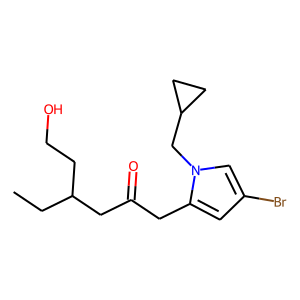

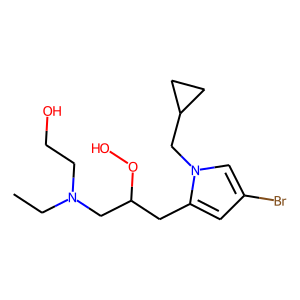

[49] invalid smiles: CCN(CCO)C(=O))c1ccc(r)cn1CC1CC1
[50] invalid smiles: CCN(CCO)C(=O))c1cc(Br)cn1CC1CC1


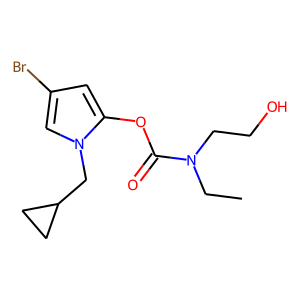

[52] invalid smiles: CCN(CCO)C(=O)Oc1cc(Br)cn1C11CC1
[53] invalid smiles: CCN(CCO)C(=O)Oc1cc(Br)cn1C11C11


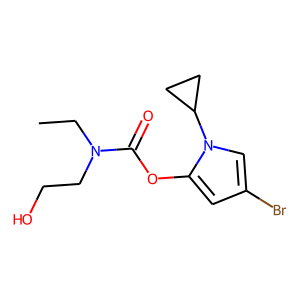

[55] invalid smiles: CCN(CCO)C(=O)cc1cc(Br)cn1C1CC1
[56] invalid smiles: CCN(CCO)C(=O)c1ccc(Br)cn1C1CC1
[57] invalid smiles: CCN(CCO)C(=O)c1cc(Br)cn1C11CC1
[58] invalid smiles: CCN(CCO)C(=O)c1cc(Br)cn1C11C1


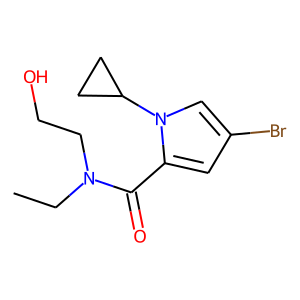

In [149]:
################ Code #################

for idx, vae_smile in enumerate(vae_smiles):
    if check_smiles_valid(vae_smile):
        img = Draw.MolToImage(Chem.MolFromSmiles(vae_smile))
        img.show()
    else:
        print(f"[{idx}] invalid smiles: {vae_smile}")

################ Code #################